In [2]:
from data_validation import *

In [3]:
# first read data
df_vgl = pd.read_parquet('data.gzip')
df_vgl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45796 entries, 2019-11-06 11:24:00.101000 to 2019-11-06 11:50:17.036436
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   v_db           7800 non-null   float64
 1   v_blf          37996 non-null  float64
 2   timestamp      45796 non-null  float64
 3   measured_time  45796 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


# Interpolate with Pandas and build crosscorrelation
- first interpolate data with pandas (method=time)
    - other methoads e. g. linear generate almost the same output
    - after interp other columns must be removed and index must be reseted
- second do cross correlation
    - values for v_blf (high frequency) fluctuate
    - correlation isn't possible for:
        - this values
        - values with time index

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 724 entries, 2019-11-06 11:24:55.142766 to 2019-11-06 11:25:19.284554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v_db    724 non-null    float64
 1   v_blf   724 non-null    float64
dtypes: float64(2)
memory usage: 17.0 KB


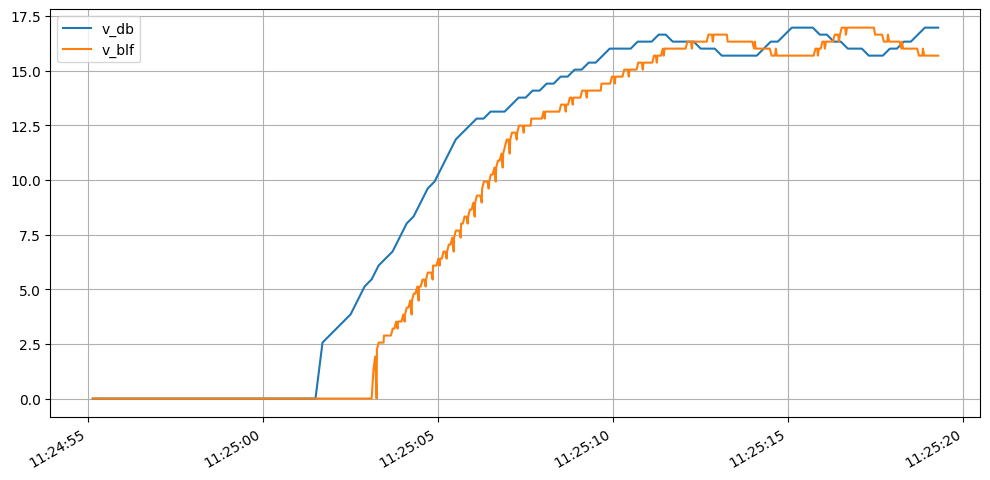

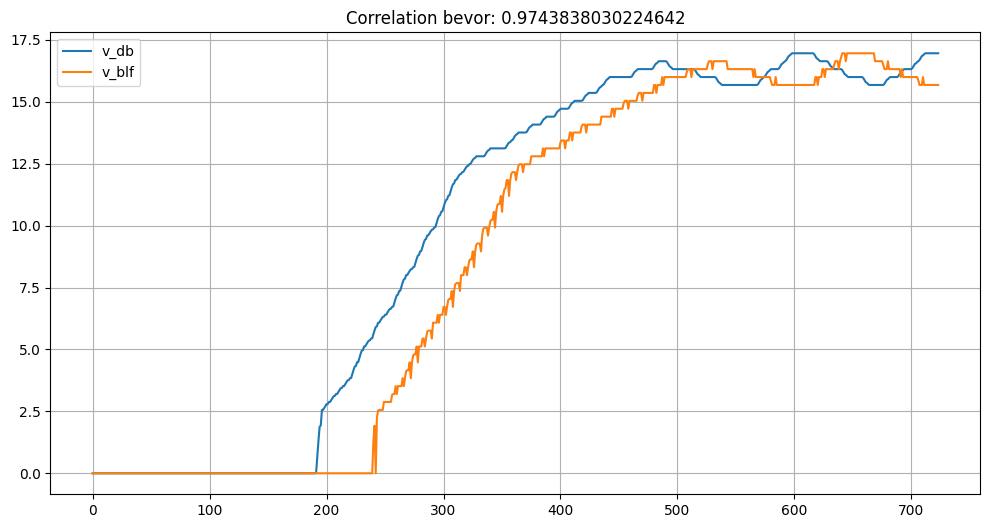

Best lag: 0


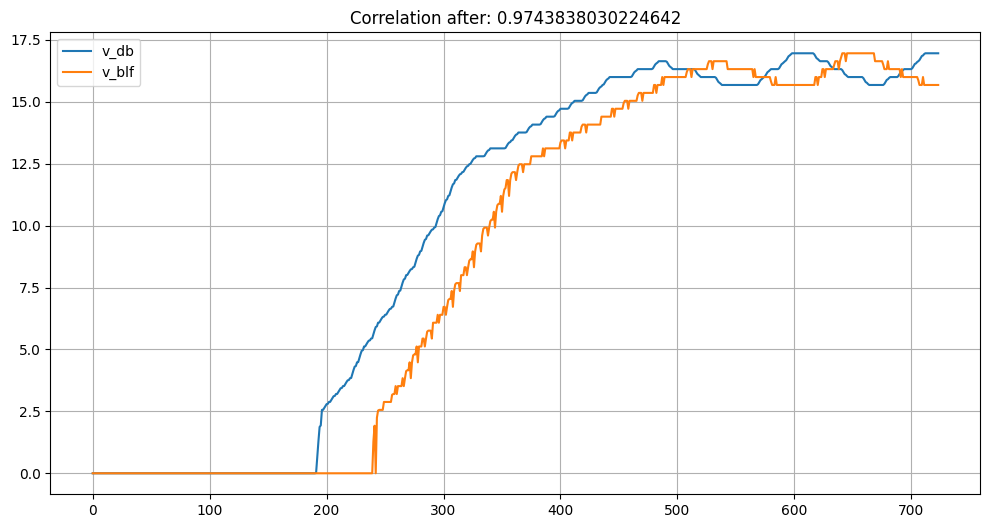

In [4]:
# only take first 1000 items
# and make the interpolation
interp_time = df_vgl.iloc[0:1000].drop(['measured_time', 'timestamp'], axis=1).interpolate(method='time').dropna()
interp_time.info()
fig, ax = plt.subplots(figsize=(12,6))
interp_time.plot(ax=ax)
ax.grid()
plt.show()


# do cross correlation
test = interp_time.reset_index(drop=True)
plot_correlation(test.v_db, test.v_blf, 'bevor')
x, y, lag = shift_for_maximum_correlation(test.v_db, test.v_blf)
plot_correlation(x, y, 'after')

# Interpolate with Numpy and build cross correlation

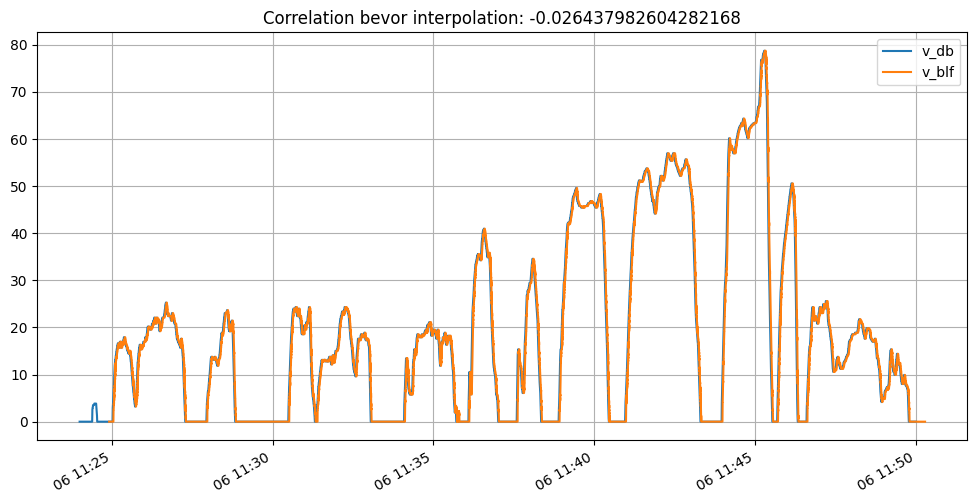

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7800 entries, 2019-11-06 11:24:00.101000 to 2019-11-06 11:49:59.964000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   v_db       7800 non-null   float64
 1   timestamp  7800 non-null   float64
dtypes: float64(2)
memory usage: 182.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37996 entries, 2019-11-06 11:24:55.142766 to 2019-11-06 11:50:17.036436
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   v_blf      37996 non-null  float64
 1   timestamp  37996 non-null  float64
dtypes: float64(2)
memory usage: 890.5 KB
None


In [5]:
# build dataframes only for db and blf data separately
#v_db_origin = df_vgl.between_time('11:25:00', '11:26:00')[['v_db', 'timestamp']].dropna()
#v_blf_origin = df_vgl.between_time('11:25:00', '11:26:00')[['v_blf', 'timestamp']].dropna()
v_db_origin = df_vgl[['v_db', 'timestamp']].dropna()
v_blf_origin = df_vgl[['v_blf', 'timestamp']].dropna()

plot_correlation(v_db_origin.v_db, v_blf_origin.v_blf, 'bevor interpolation')

print(v_db_origin.info())
print(v_blf_origin.info())

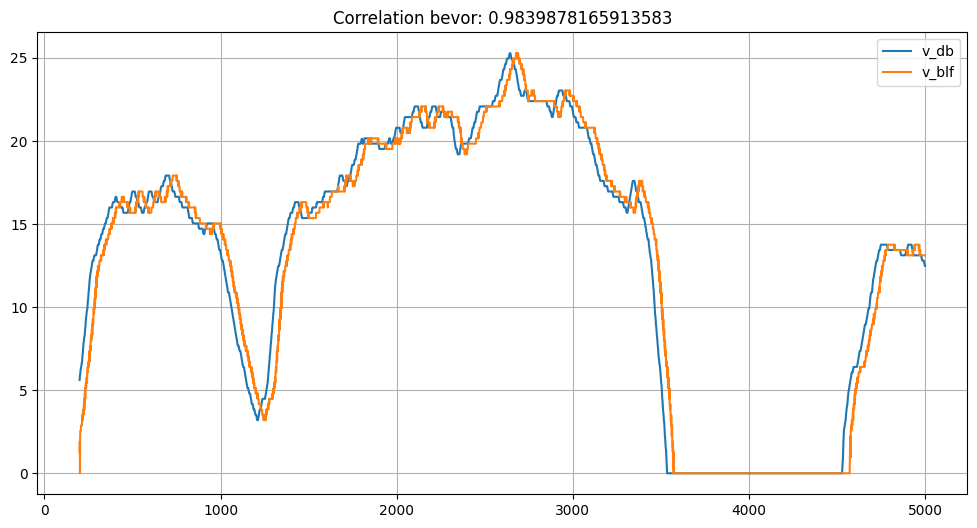

Best lag: -39


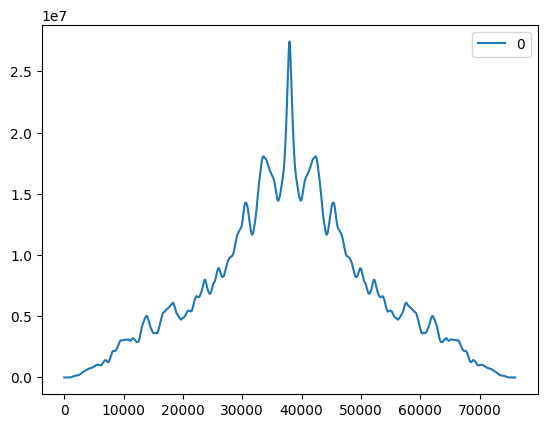

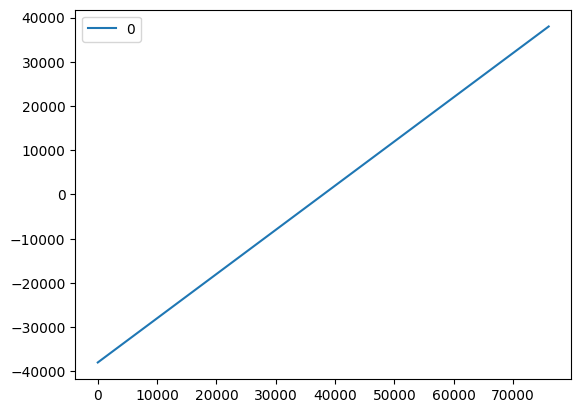

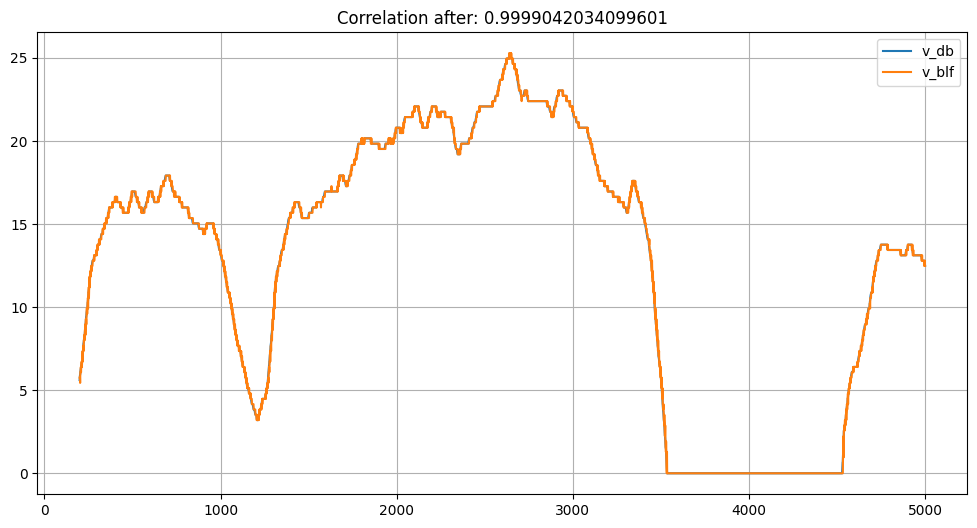

time diff 
first: 	0.20000004768371582 
mean: 	0.040054049638964424 
min: 	0.0
max: 	0.05181407928466797

time shift: -1.5621079359196126


In [6]:
# interpolate db values
v_db_interp = np.interp(v_blf_origin.timestamp, v_db_origin.timestamp, v_db_origin.v_db)
df = v_blf_origin.copy()
df['v_db'] = v_db_interp
# df = df.drop(['timestamp'], axis=1)

#test = df[200:1000].reset_index(drop=True)
# test = df.between_time('11:25:00', '11:30:00').reset_index(drop=True)
test = df.reset_index(drop=True)

# do cross correlation
plot_correlation(test.v_db[200:5000], test.v_blf[200:5000], 'bevor')
correlation = correlate(test.v_db, test.v_blf)
correlation = pd.DataFrame(correlation)
correlation.plot()
lags = correlation_lags(test.v_db.size, test.v_blf.size, mode="full")
pd.DataFrame(lags).plot()
x, y, lag = shift_for_maximum_correlation(test.v_db, test.v_blf)
plot_correlation(x[200:5000], y[200:5000], 'after')

# calc time shift
time_diff = list()
time_bevor = df.timestamp.iloc[0]
for i in range(len(df.index)):
    time_diff.append(df.timestamp.iloc[i] - time_bevor)
    time_bevor = df.timestamp.iloc[i]
df['time_diff'] = time_diff
time_diff_first = v_db_origin.timestamp[1] - v_db_origin.timestamp[0]
print('time diff \nfirst: \t{time_diff_first} \nmean: \t{time_diff_mean} \nmin: \t{time_diff_min}\nmax: \t{time_diff_max}\n'.format(
    time_diff_first=time_diff_first, time_diff_mean=df.time_diff.mean(), time_diff_max=df.time_diff.max(), time_diff_min=df.time_diff.min()))

time_shift=lag*df.time_diff.mean()
print('time shift: {time_shift}'.format(time_shift=time_shift))

<AxesSubplot:>

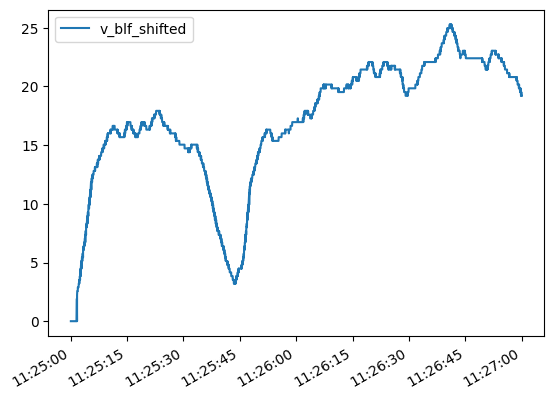

In [12]:
# plot data with time shift
# df_shift = df_vgl.copy()
# time_shift = -10
v_blf_shifted = df_vgl[['v_blf']].copy().dropna()
v_blf_shifted = v_blf_shifted.shift(periods=round(time_shift,9), freq="S").rename(columns={'v_blf': 'v_blf_shifted'})
v_blf_shifted.between_time('11:25', '11:27').plot()